# Prediciendo la enfermedad cardiaca usando regresión logística

El dataset Framingham Heart Study es un conjunto de datos famoso en el campo de la epidemiología y la medicina. La ciudad de Framingham, Massachusetts, en los Estados Unidos, ha sido la sede de un estudio a largo plazo sobre la salud del corazón que comenzó en 1948. Desde entonces, los datos recopilados en Framingham han sido vitales para nuestra comprensión de la enfermedad cardiovascular.

El estudio de Framingham fue uno de los primeros en identificar la hipertensión, el colesterol alto, el tabaquismo, la obesidad, la diabetes y otros factores como riesgos clave para el desarrollo de enfermedades del corazón. Los investigadores han seguido a miles de participantes durante décadas, recopilando datos sobre su salud, sus hábitos de vida y sus condiciones médicas.

## Descripción de las variables

* male: si es hombre o no (cateegorica)
* education: nivel educativo (categorica)
* currentSmoker: si fuma o no (categorica)
* cigsPerDay: numero de cigarros que fuma por dia (continua)
* BPMeds: si el paciente ha tomado medicamentos para la presion arterial (categorica)
* prevalentStroke: si el paciente ha tenido un ACV (categorica)
* prevalentHyp: si el paciente es hipertenso (cat)
* diabetes: idem diabetes
* totChol: nivel de colesterol (cont)
* sysBP: presion arterial sistolica (cont)
* diaBP: presion arterial diastolica (cont)
* BMI: Indice de masa corporal (cont)
* heartRate: frecuencia cardiaca (cont)
* glucose: nivel de glucosa (cont)
* TenYearCHD: Riesgo de 10 años de cardiopatía coronaria CHD (esta sera nuestra variable target)

Es importante recordar que aunque los datos del estudio de Framingham han proporcionado muchas ideas valiosas sobre la enfermedad del corazón, los participantes en el estudio son predominantemente de raza blanca y de un área geográfica específica, por lo que los hallazgos pueden no ser generalizables a todas las poblaciones.

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('framingham.csv')
df.head()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


## Analisis exploratorio y pre-procesamiento de datos

Acá se deben ver como se distirbuyen las variables, descartar las que estan correlacionadas entre si, y tratar los valores faltantes

Por simplicidad y en vista de querer evitar posibles colinealidades, vamos a descartar algunas variables que parecen ser redundantes con otras. Por ejemplo, 0 cigarros por día es equivalente a que no fume. La presió diastólica por lo general está muy correlacionada con la sistólica, y las presión alta está determinada principalmente por esta última. La variable de glucosa se eliminará también, favorenciendo a la variable categórica de la prevalencia de diabetes. 

In [3]:
df.drop(['currentSmoker','diaBP','glucose'], axis = 1, inplace = True)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4238 entries, 0 to 4237
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   male             4238 non-null   int64  
 1   age              4238 non-null   int64  
 2   education        4133 non-null   float64
 3   cigsPerDay       4209 non-null   float64
 4   BPMeds           4185 non-null   float64
 5   prevalentStroke  4238 non-null   int64  
 6   prevalentHyp     4238 non-null   int64  
 7   diabetes         4238 non-null   int64  
 8   totChol          4188 non-null   float64
 9   sysBP            4238 non-null   float64
 10  BMI              4219 non-null   float64
 11  heartRate        4237 non-null   float64
 12  TenYearCHD       4238 non-null   int64  
dtypes: float64(7), int64(6)
memory usage: 430.5 KB


Vamos a tratar los valores faltantes eliminándolos

In [5]:
df.isnull().sum()

male                 0
age                  0
education          105
cigsPerDay          29
BPMeds              53
prevalentStroke      0
prevalentHyp         0
diabetes             0
totChol             50
sysBP                0
BMI                 19
heartRate            1
TenYearCHD           0
dtype: int64

In [6]:
df.dropna(inplace=True)
df.isnull().sum()

male               0
age                0
education          0
cigsPerDay         0
BPMeds             0
prevalentStroke    0
prevalentHyp       0
diabetes           0
totChol            0
sysBP              0
BMI                0
heartRate          0
TenYearCHD         0
dtype: int64

## Preparación de los datos para el modelo



Ahora, debemos tratar los atributos que son categóricos. Recordar que se debe borrar una categoría base para evitar la multicolinealidad perfecta o "trampa de la variable dummy". Esta vez lo haremos usando el argumento drop_first

In [7]:
dummies_male = pd.get_dummies(df.male, drop_first=True) 
dummies_education = pd.get_dummies(df.education, drop_first=True)
dummies_BPMeds = pd.get_dummies(df.BPMeds, drop_first=True)
dummies_prevalentStroke= pd.get_dummies(df.prevalentStroke, drop_first=True)
dummies_prevalentHyp = pd.get_dummies(df.prevalentHyp, drop_first=True)
dummies_diabetes = pd.get_dummies(df.diabetes , drop_first=True)

In [8]:
dummies_male

,1
0,1
1,0
2,1
3,0
4,0
...,...
4232,1
4233,1
4234,1
4236,0


In [9]:
dummies_education

,2.0,3.0,4.0
0,0,0,1
1,1,0,0
2,0,0,0
3,0,1,0
4,0,1,0
...,...,...,...
4232,0,0,0
4233,0,0,0
4234,0,1,0
4236,0,0,0


In [10]:
dummies_BPMeds

,1.0
0,0
1,0
2,0
3,0
4,0
...,...
4232,0
4233,0
4234,0
4236,0


In [11]:
dummies_prevalentStroke

,1
0,0
1,0
2,0
3,0
4,0
...,...
4232,0
4233,0
4234,0
4236,0


**Nota**: **one-hot** encoding tambien se puede usar

Para evitar confusiones a la hora de interpretar el output del modelo, cambiamos los nombres de la columna dummie

In [12]:
dummies_male.columns = ['male']
dummies_education.columns = ['educ_2','educ_3','educ_4']
dummies_BPMeds.columns = ['prev_BPMeds']
dummies_prevalentStroke.columns = ['prev_stroke']
dummies_prevalentHyp.columns = ['prev_hyp']
dummies_diabetes.columns = ['prev_diabetes']

Ahora, empezamos a construir las matrices de atributos y de respuesta del modelo

In [13]:
X = df.drop(['male','education','BPMeds','prevalentStroke','prevalentHyp','diabetes','TenYearCHD'],axis=1)
X = pd.concat([X, dummies_male, dummies_education,dummies_BPMeds, dummies_prevalentStroke,dummies_prevalentHyp, dummies_diabetes], axis =1)
X

,age,cigsPerDay,totChol,sysBP,BMI,heartRate,male,educ_2,educ_3,educ_4,prev_BPMeds,prev_stroke,prev_hyp,prev_diabetes
0,39,0.0,195.0,106.0,26.97,80.0,1,0,0,1,0,0,0,0
1,46,0.0,250.0,121.0,28.73,95.0,0,1,0,0,0,0,0,0
2,48,20.0,245.0,127.5,25.34,75.0,1,0,0,0,0,0,0,0
3,61,30.0,225.0,150.0,28.58,65.0,0,0,1,0,0,0,1,0
4,46,23.0,285.0,130.0,23.10,85.0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4232,68,0.0,176.0,168.0,23.14,60.0,1,0,0,0,0,0,1,0
4233,50,1.0,313.0,179.0,25.97,66.0,1,0,0,0,0,0,1,0
4234,51,43.0,207.0,126.5,19.71,65.0,1,0,1,0,0,0,0,0
4236,44,15.0,210.0,126.5,19.16,86.0,0,0,0,0,0,0,0,0


In [14]:
y = df['TenYearCHD']
y

0       0
1       0
2       0
3       1
4       0
       ..
4232    1
4233    1
4234    0
4236    0
4237    0
Name: TenYearCHD, Length: 3987, dtype: int64

Ahora separamos entre entrenamiento y prueba

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

Y ahora normalizamos la data (advertenecia: si este paso no se hace, saldrá una advertencia adelante: que el modelo no converge y se necesita aumentar el numero de iteraciones o bien, normalizar los datos, haga la prueba!)

In [16]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)

X_test = scaler.transform(X_test)

## Ajuste y predicción

El clásico fit y predict 

In [17]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train,y_train)

y_pred = model.predict(X_test)

Imprimimos los coeficientes.

In [18]:
print(f'Coeficientes : {model.coef_}')
print(f'Sesgo : {model.intercept_}')

Coeficientes : [[ 2.29270643  1.42863442  0.53267149  2.13206636  0.51090979 -0.13327239
   0.47125351 -0.23719787 -0.23404044 -0.17187802  0.48168934  0.72377341
   0.24103246  0.80993564]]
Sesgo : [-4.11317878]


In [19]:
X.columns

Index(['age', 'cigsPerDay', 'totChol', 'sysBP', 'BMI', 'heartRate', 'male',
       'educ_2', 'educ_3', 'educ_4', 'prev_BPMeds', 'prev_stroke', 'prev_hyp',
       'prev_diabetes'],
      dtype='object')

In [20]:
pd.DataFrame(model.coef_, columns =X.columns )

,age,cigsPerDay,totChol,sysBP,BMI,heartRate,male,educ_2,educ_3,educ_4,prev_BPMeds,prev_stroke,prev_hyp,prev_diabetes
0,2.292706,1.428634,0.532671,2.132066,0.51091,-0.133272,0.471254,-0.237198,-0.23404,-0.171878,0.481689,0.723773,0.241032,0.809936


Obtenemos los odd ratios a partir de la exponencial de los coeficientes. Recordar que los valores mayores 1 influye positivamente en la probabilidad del target (enfermedad coronaria)

In [21]:
import numpy as np
pd.DataFrame(np.exp(model.coef_), columns =X.columns )

,age,cigsPerDay,totChol,sysBP,BMI,heartRate,male,educ_2,educ_3,educ_4,prev_BPMeds,prev_stroke,prev_hyp,prev_diabetes
0,9.9017,4.172997,1.703477,8.432273,1.666807,0.875227,1.602001,0.788835,0.79133,0.842082,1.618807,2.0622,1.272562,2.247763


¿Cómo anda el sobreajuste?

In [22]:
print(f'Test accuracy: {model.score(X_test,y_test)}')
print(f'Train accuracy: {model.score(X_train,y_train)}')

Test accuracy: 0.8521303258145363
Train accuracy: 0.8551269990592663


## Evaluación

Calcular metricas de evaluacion, ROC y AUC

In [23]:
from sklearn.metrics import confusion_matrix

matriz_confusion = pd.DataFrame(confusion_matrix(y_test, y_pred), columns = ['Predicted Positive', 'Predicted Negative'], 
                  index=['Actual Positive', 'Actual Negative'])
matriz_confusion

,Predicted Positive,Predicted Negative
Actual Positive,673,7
Actual Negative,111,7


In [24]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.99      0.92       680
           1       0.50      0.06      0.11       118

    accuracy                           0.85       798
   macro avg       0.68      0.52      0.51       798
weighted avg       0.81      0.85      0.80       798



In [25]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print("Accuracy:", accuracy_score(y_test,y_pred))
print("Precision:", precision_score(y_test, y_pred, ))
print("Recall:", recall_score(y_test,y_pred))
print("F1 Score:", f1_score(y_test,y_pred))

Accuracy: 0.8521303258145363
Precision: 0.5
Recall: 0.059322033898305086
F1 Score: 0.10606060606060608


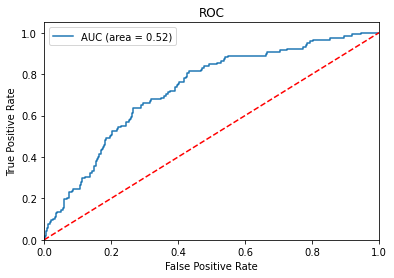

In [26]:
# Area Under Curve - AUC
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve
model_roc_auc = roc_auc_score(y_test, model.predict(X_test))

fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='AUC (area = %0.2f)' % model_roc_auc)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim(([0.0, 1.0]))
plt.ylim(([0.0, 1.05]))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend()
plt.show()

¿Se puede enmendar el modelo?

¿qué puede haber pasado?

Como dice la metodología CRISP-DM, debemos ir hacia atrás

Veamos cómo anda la clase target, que fue un paso que no hicimos antes

C:\Users\aleph\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='TenYearCHD', ylabel='count'>

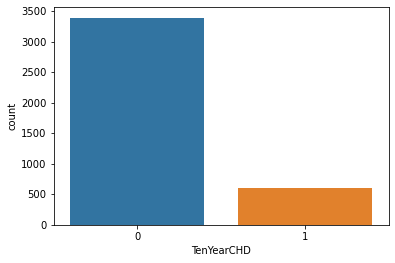

In [27]:
import seaborn as sns
sns.countplot(df.TenYearCHD)

Estamos frente a **datos desbalanceados**, y esto se podría haber pensando desde la comprensión del problema. La enfermedad coronaria es algo raro, no masivo, afortundamente, por lo tanto, es de esperar que se tengan datos desbalanceados en cualquier muestra. Si esto pasa, es porque el modelo está reconociendo más las clase "0" y muy poco la clase "1". Esto ya lo podemos sospechar desde los valores de la precisión y la sensibilidad.

Existen diversas técnica de balanceo de clases. Una de ellas es SMOTE, que lo que hace -coloquialmente hablando- es simular más datos de la clase desfavorecida cosa de balancear el problema.

In [28]:
!pip install imblearn

In [29]:
from imblearn.over_sampling import SMOTE


sm = SMOTE(random_state = 2)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train.ravel())

clf = LogisticRegression()
model_res = clf.fit(X_train_res, y_train_res)

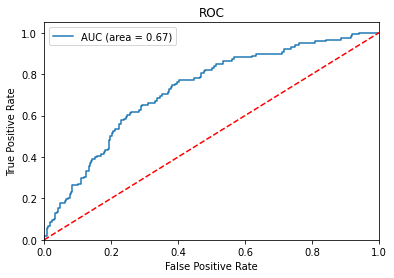

In [30]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve
model_roc_auc = roc_auc_score(y_test, model_res.predict(X_test))

fpr, tpr, thresholds = roc_curve(y_test, model_res.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='AUC (area = %0.2f)' % model_roc_auc)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim(([0.0, 1.0]))
plt.ylim(([0.0, 1.05]))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend()
plt.show()

**Ejercicios**

- Verificar que los datos bajo SMOTE están balanceados
- Calcular matriz de confusión, y medidas de evaluación del nuevo modelo balanceado
- Ver si con otra selección de variables este modelo mejora su evaluación
- Verificar si con validación cruzada, el AUC mejora


In [31]:
# re-interpretando

pd.DataFrame(np.exp(model_res.coef_), columns =X.columns )

,age,cigsPerDay,totChol,sysBP,BMI,heartRate,male,educ_2,educ_3,educ_4,prev_BPMeds,prev_stroke,prev_hyp,prev_diabetes
0,15.742856,5.788585,2.712919,16.794556,1.625658,0.549581,1.627725,0.891811,0.832683,0.763708,1.694274,1.579326,1.118656,2.111061


In [32]:
import os
os.getcwd()

'C:\\Users\\aleph\\OneDrive\\Escritorio\\UDLA Mg DS'